In [199]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pets-facial-expression-dataset/Other/aug-88-54.jpg
/kaggle/input/pets-facial-expression-dataset/Other/45.jpg
/kaggle/input/pets-facial-expression-dataset/Other/56.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-141-02.jpg
/kaggle/input/pets-facial-expression-dataset/Other/20.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-37-49.jpg
/kaggle/input/pets-facial-expression-dataset/Other/58.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-168-37.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-80-43.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-183-55.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-114-30.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-152-19.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-180-52.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-195-12.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-123-39.jpg
/kaggle/input/pets-facial-expression-dataset/

In [200]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [201]:
!pip install torch-lr-finder


  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)


In [202]:
#Importing Libraries
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
from torch import optim
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision.models as models
import PIL


In [203]:
#Setting the path
data_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder'
ds_name = 'Pets Facial Expression'

In [204]:
#Printing the classes
print(os.listdir(data_dir))

train_class = os.listdir(data_dir + "/train")
valid_class = os.listdir(data_dir + "/valid")
test_class = os.listdir(data_dir + "/test")

print(f"train class is {train_class}")
print(f"valid class is {valid_class}")
print(f"test class is {test_class}")

['valid', 'test', 'train']
train class is ['Other', 'Angry', 'Sad', 'happy']
valid class is ['Other', 'Angry', 'Sad', 'happy']
test class is ['Other', 'Angry', 'Sad', 'happy']


In [205]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),        
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(15),         
    transforms.ToTensor(),                
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [206]:
#Creating a Imagefolder
train_dataset = ImageFolder(data_dir + "/train", transform=transform)
test_dataset = ImageFolder(data_dir + "/test",transform=transform)
val_dataset = ImageFolder(data_dir + "/valid", transform=transform)

In [207]:
#shape of images
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [208]:
#Visualizing some images
def show_image(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  happy (3)


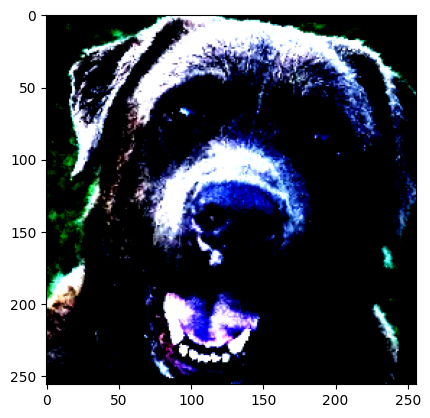

In [209]:
show_image(*train_dataset[966])

Label:  Angry (0)


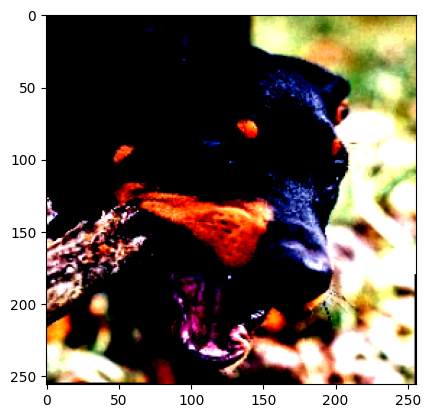

In [210]:
show_image(*train_dataset[69])

In [211]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform= test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 16, shuffle= True, pin_memory= False)
test_loader = DataLoader(test_data,
                         batch_size= 16, shuffle= False, pin_memory= False)
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['Angry', 'Other', 'Sad', 'happy']
Number of train images: 1000
Number of test images: 38


In [212]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = models.vgg16(pretrained=True)
summary(model.to(device), input_size=(3, 224, 224))


Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             R

In [213]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lambda1=0.005
criterion = nn.CrossEntropyLoss()
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1=l1+p.abs().sum()
        loss = loss+lambda1*l1.detach()
        train_losses.append(loss.detach())
        loss.backward()
        optimizer.step()
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).detach()#F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [214]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for name, param in model.named_parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(model)

In [215]:
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
model.classifier = nn.Sequential(*features)

In [216]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.6.weight
classifier.6.bias


In [217]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.6.weight
	 classifier.6.bias


In [218]:
model =  model.to(device)

/opt/conda/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-03


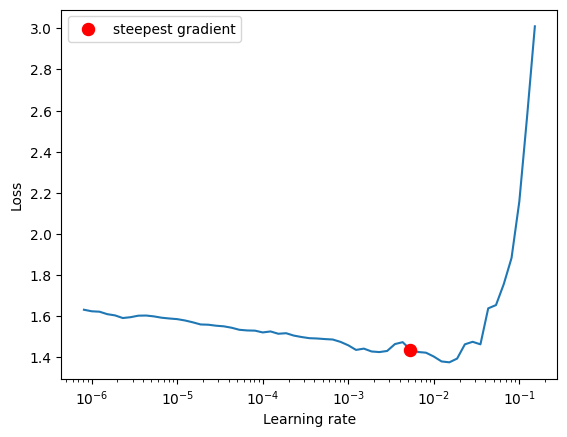

In [219]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [220]:
model =  model.to(device)
optimizer = torch.optim.SGD(params_to_update, lr=1e-03, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-03, max_lr=0.5, step_size_up=15)
EPOCHS = 45
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=3758.667724609375 Batch_id=62 Accuracy=47.20: 100%|██████████| 63/63 [00:07<00:00,  8.46it/s]


current Learning Rate:  0.03426666666666677

Test set: Average loss: 0.1420, Accuracy: 18/38 (47.37%)

EPOCH: 1


Loss=3780.37548828125 Batch_id=62 Accuracy=48.30: 100%|██████████| 63/63 [00:07<00:00,  8.57it/s] 


current Learning Rate:  0.06753333333333332

Test set: Average loss: 2.4693, Accuracy: 15/38 (39.47%)

EPOCH: 2


Loss=3814.451416015625 Batch_id=62 Accuracy=56.30: 100%|██████████| 63/63 [00:07<00:00,  8.41it/s]


current Learning Rate:  0.10080000000000008

Test set: Average loss: 4.9084, Accuracy: 20/38 (52.63%)

EPOCH: 3


Loss=3813.03515625 Batch_id=62 Accuracy=60.50: 100%|██████████| 63/63 [00:08<00:00,  7.75it/s]    


current Learning Rate:  0.13406666666666664

Test set: Average loss: 6.4763, Accuracy: 18/38 (47.37%)

EPOCH: 4


Loss=3881.70458984375 Batch_id=62 Accuracy=62.10: 100%|██████████| 63/63 [00:07<00:00,  8.50it/s] 


current Learning Rate:  0.16733333333333342

Test set: Average loss: 5.0778, Accuracy: 21/38 (55.26%)

EPOCH: 5


Loss=3851.932373046875 Batch_id=62 Accuracy=63.70: 100%|██████████| 63/63 [00:07<00:00,  8.41it/s]


current Learning Rate:  0.20059999999999995

Test set: Average loss: 7.1004, Accuracy: 17/38 (44.74%)

EPOCH: 6


Loss=3871.2939453125 Batch_id=62 Accuracy=66.80: 100%|██████████| 63/63 [00:07<00:00,  8.45it/s]  


current Learning Rate:  0.23386666666666672

Test set: Average loss: 13.8202, Accuracy: 19/38 (50.00%)

EPOCH: 7


Loss=3920.59375 Batch_id=62 Accuracy=68.30: 100%|██████████| 63/63 [00:07<00:00,  8.01it/s]       


current Learning Rate:  0.2671333333333333

Test set: Average loss: 15.7215, Accuracy: 18/38 (47.37%)

EPOCH: 8


Loss=3972.040771484375 Batch_id=62 Accuracy=74.80: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


current Learning Rate:  0.30040000000000006

Test set: Average loss: 17.1538, Accuracy: 19/38 (50.00%)

EPOCH: 9


Loss=4010.049560546875 Batch_id=62 Accuracy=70.40: 100%|██████████| 63/63 [00:07<00:00,  8.39it/s]


current Learning Rate:  0.3336666666666666

Test set: Average loss: 19.2087, Accuracy: 14/38 (36.84%)

EPOCH: 10


Loss=3994.762451171875 Batch_id=62 Accuracy=69.90: 100%|██████████| 63/63 [00:07<00:00,  8.43it/s]


current Learning Rate:  0.3669333333333334

Test set: Average loss: 17.8886, Accuracy: 16/38 (42.11%)

EPOCH: 11


Loss=3985.013671875 Batch_id=62 Accuracy=73.70: 100%|██████████| 63/63 [00:07<00:00,  8.17it/s]   


current Learning Rate:  0.4001999999999999

Test set: Average loss: 18.4768, Accuracy: 20/38 (52.63%)

EPOCH: 12


Loss=4031.708984375 Batch_id=62 Accuracy=73.50: 100%|██████████| 63/63 [00:07<00:00,  8.35it/s]   


current Learning Rate:  0.43346666666666667

Test set: Average loss: 17.9070, Accuracy: 19/38 (50.00%)

EPOCH: 13


Loss=4017.610595703125 Batch_id=62 Accuracy=75.10: 100%|██████████| 63/63 [00:07<00:00,  8.41it/s]


current Learning Rate:  0.46673333333333344

Test set: Average loss: 18.3322, Accuracy: 19/38 (50.00%)

EPOCH: 14


Loss=4053.430908203125 Batch_id=62 Accuracy=75.30: 100%|██████████| 63/63 [00:07<00:00,  8.23it/s]


current Learning Rate:  0.5

Test set: Average loss: 19.2945, Accuracy: 18/38 (47.37%)

EPOCH: 15


Loss=3999.04833984375 Batch_id=62 Accuracy=76.10: 100%|██████████| 63/63 [00:08<00:00,  7.53it/s] 


current Learning Rate:  0.46673333333333344

Test set: Average loss: 26.9606, Accuracy: 18/38 (47.37%)

EPOCH: 16


Loss=4061.671142578125 Batch_id=62 Accuracy=77.00: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


current Learning Rate:  0.43346666666666667

Test set: Average loss: 25.0910, Accuracy: 20/38 (52.63%)

EPOCH: 17


Loss=4176.875 Batch_id=62 Accuracy=75.20: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s]         


current Learning Rate:  0.4001999999999999

Test set: Average loss: 29.8712, Accuracy: 18/38 (47.37%)

EPOCH: 18


Loss=4240.94580078125 Batch_id=62 Accuracy=76.60: 100%|██████████| 63/63 [00:07<00:00,  8.35it/s] 


current Learning Rate:  0.3669333333333334

Test set: Average loss: 32.0181, Accuracy: 21/38 (55.26%)

EPOCH: 19


Loss=4072.930908203125 Batch_id=62 Accuracy=77.80: 100%|██████████| 63/63 [00:07<00:00,  8.26it/s]


current Learning Rate:  0.33366666666666683

Test set: Average loss: 30.4835, Accuracy: 19/38 (50.00%)

EPOCH: 20


Loss=4099.1318359375 Batch_id=62 Accuracy=78.50: 100%|██████████| 63/63 [00:07<00:00,  8.44it/s]  


current Learning Rate:  0.30040000000000006

Test set: Average loss: 26.8104, Accuracy: 16/38 (42.11%)

EPOCH: 21


Loss=4048.887451171875 Batch_id=62 Accuracy=81.30: 100%|██████████| 63/63 [00:07<00:00,  8.45it/s]


current Learning Rate:  0.2671333333333333

Test set: Average loss: 28.0937, Accuracy: 19/38 (50.00%)

EPOCH: 22


Loss=4142.42919921875 Batch_id=62 Accuracy=81.10: 100%|██████████| 63/63 [00:07<00:00,  8.30it/s] 


current Learning Rate:  0.23386666666666672

Test set: Average loss: 28.4299, Accuracy: 19/38 (50.00%)

EPOCH: 23


Loss=4103.849609375 Batch_id=62 Accuracy=80.60: 100%|██████████| 63/63 [00:07<00:00,  8.18it/s]   


current Learning Rate:  0.20059999999999995

Test set: Average loss: 25.3097, Accuracy: 21/38 (55.26%)

EPOCH: 24


Loss=4078.71337890625 Batch_id=62 Accuracy=83.20: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s] 


current Learning Rate:  0.1673333333333332

Test set: Average loss: 24.5358, Accuracy: 19/38 (50.00%)

EPOCH: 25


Loss=4087.76904296875 Batch_id=62 Accuracy=84.70: 100%|██████████| 63/63 [00:07<00:00,  8.26it/s] 


current Learning Rate:  0.13406666666666664

Test set: Average loss: 23.4457, Accuracy: 19/38 (50.00%)

EPOCH: 26


Loss=4071.75537109375 Batch_id=62 Accuracy=86.50: 100%|██████████| 63/63 [00:07<00:00,  8.43it/s] 


current Learning Rate:  0.10080000000000008

Test set: Average loss: 23.5251, Accuracy: 17/38 (44.74%)

EPOCH: 27


Loss=4124.2314453125 Batch_id=62 Accuracy=83.80: 100%|██████████| 63/63 [00:07<00:00,  8.20it/s]  


current Learning Rate:  0.06753333333333332

Test set: Average loss: 23.0203, Accuracy: 18/38 (47.37%)

EPOCH: 28


Loss=4056.786865234375 Batch_id=62 Accuracy=85.60: 100%|██████████| 63/63 [00:07<00:00,  8.40it/s]


current Learning Rate:  0.03426666666666655

Test set: Average loss: 22.9986, Accuracy: 19/38 (50.00%)

EPOCH: 29


Loss=4059.840087890625 Batch_id=62 Accuracy=87.80: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s]


current Learning Rate:  0.001

Test set: Average loss: 25.4342, Accuracy: 20/38 (52.63%)

EPOCH: 30


Loss=4060.951416015625 Batch_id=62 Accuracy=87.40: 100%|██████████| 63/63 [00:07<00:00,  8.30it/s]


current Learning Rate:  0.03426666666666655

Test set: Average loss: 25.2265, Accuracy: 20/38 (52.63%)

EPOCH: 31


Loss=4056.208984375 Batch_id=62 Accuracy=86.60: 100%|██████████| 63/63 [00:07<00:00,  8.18it/s]   


current Learning Rate:  0.0675333333333331

Test set: Average loss: 23.2555, Accuracy: 20/38 (52.63%)

EPOCH: 32


Loss=4094.577392578125 Batch_id=62 Accuracy=87.30: 100%|██████████| 63/63 [00:07<00:00,  8.48it/s]


current Learning Rate:  0.10080000000000008

Test set: Average loss: 25.3544, Accuracy: 21/38 (55.26%)

EPOCH: 33


Loss=4111.21630859375 Batch_id=62 Accuracy=84.60: 100%|██████████| 63/63 [00:07<00:00,  8.48it/s] 


current Learning Rate:  0.13406666666666664

Test set: Average loss: 23.0750, Accuracy: 19/38 (50.00%)

EPOCH: 34


Loss=4056.53369140625 Batch_id=62 Accuracy=85.80: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s] 


current Learning Rate:  0.16733333333333364

Test set: Average loss: 25.4756, Accuracy: 19/38 (50.00%)

EPOCH: 35


Loss=4131.6728515625 Batch_id=62 Accuracy=83.50: 100%|██████████| 63/63 [00:07<00:00,  8.25it/s]  


current Learning Rate:  0.20060000000000017

Test set: Average loss: 27.4469, Accuracy: 20/38 (52.63%)

EPOCH: 36


Loss=4136.22900390625 Batch_id=62 Accuracy=85.40: 100%|██████████| 63/63 [00:07<00:00,  8.41it/s] 


current Learning Rate:  0.23386666666666672

Test set: Average loss: 27.4954, Accuracy: 19/38 (50.00%)

EPOCH: 37


Loss=4079.166259765625 Batch_id=62 Accuracy=83.50: 100%|██████████| 63/63 [00:07<00:00,  8.30it/s]


current Learning Rate:  0.2671333333333333

Test set: Average loss: 25.1264, Accuracy: 20/38 (52.63%)

EPOCH: 38


Loss=4073.31640625 Batch_id=62 Accuracy=82.20: 100%|██████████| 63/63 [00:07<00:00,  8.21it/s]    


current Learning Rate:  0.30039999999999983

Test set: Average loss: 26.3783, Accuracy: 18/38 (47.37%)

EPOCH: 39


Loss=4077.58203125 Batch_id=62 Accuracy=84.50: 100%|██████████| 63/63 [00:07<00:00,  8.10it/s]    


current Learning Rate:  0.3336666666666664

Test set: Average loss: 27.4150, Accuracy: 18/38 (47.37%)

EPOCH: 40


Loss=4072.34326171875 Batch_id=62 Accuracy=84.50: 100%|██████████| 63/63 [00:07<00:00,  8.45it/s] 


current Learning Rate:  0.3669333333333334

Test set: Average loss: 27.6471, Accuracy: 19/38 (50.00%)

EPOCH: 41


Loss=4204.005859375 Batch_id=62 Accuracy=83.50: 100%|██████████| 63/63 [00:07<00:00,  8.39it/s]   


current Learning Rate:  0.4001999999999999

Test set: Average loss: 29.7420, Accuracy: 17/38 (44.74%)

EPOCH: 42


Loss=4083.36376953125 Batch_id=62 Accuracy=82.90: 100%|██████████| 63/63 [00:07<00:00,  8.43it/s] 


current Learning Rate:  0.4334666666666669

Test set: Average loss: 30.3994, Accuracy: 19/38 (50.00%)

EPOCH: 43


Loss=4118.1875 Batch_id=62 Accuracy=83.50: 100%|██████████| 63/63 [00:07<00:00,  8.22it/s]        


current Learning Rate:  0.46673333333333344

Test set: Average loss: 29.6575, Accuracy: 18/38 (47.37%)

EPOCH: 44


Loss=4110.91455078125 Batch_id=62 Accuracy=82.50: 100%|██████████| 63/63 [00:07<00:00,  8.41it/s] 


current Learning Rate:  0.5

Test set: Average loss: 23.7892, Accuracy: 22/38 (57.89%)



Text(0.5, 1.0, 'Test Accuracy')

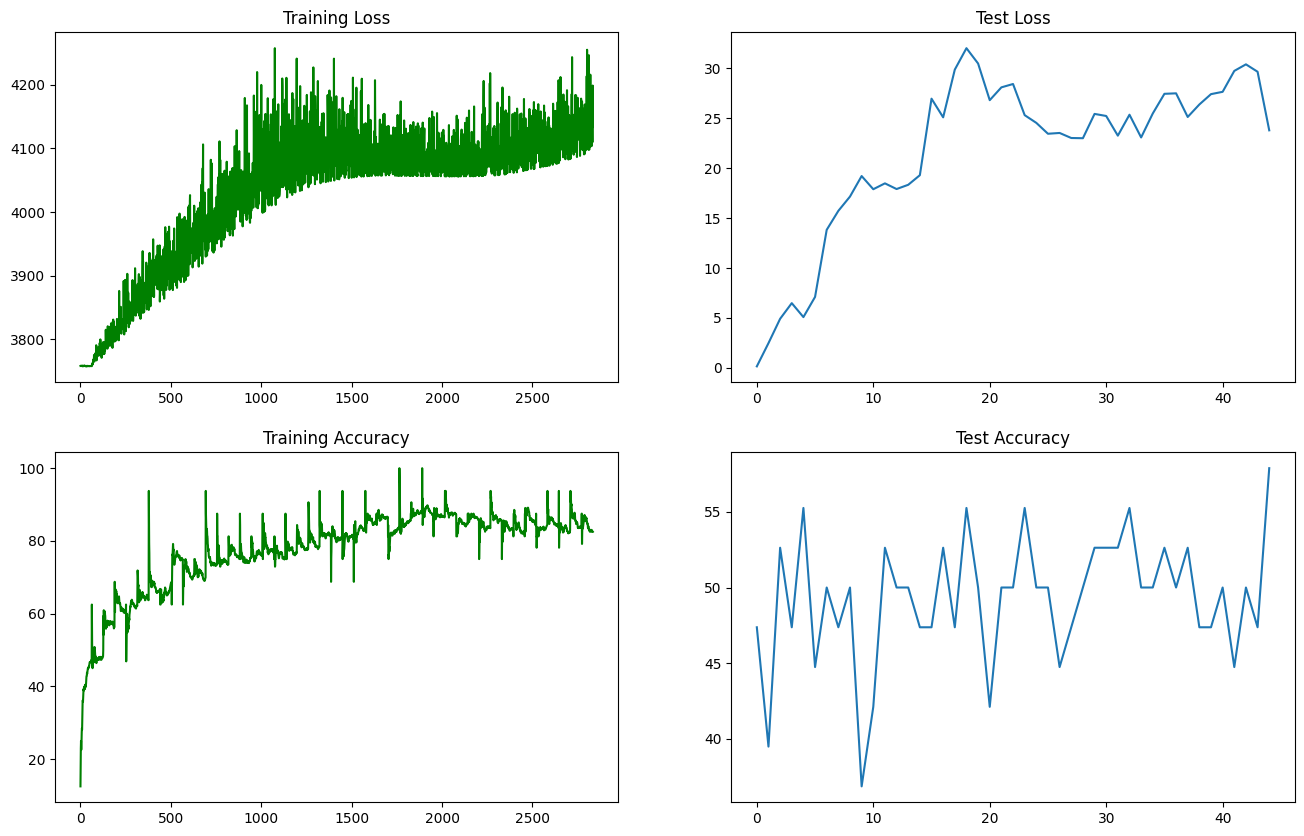

In [221]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [float(i.cpu().detach().numpy()) for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")